#KNN

In [27]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

from operator import itemgetter
from tabulate import tabulate

from sklearn.preprocessing    import StandardScaler
from sklearn.decomposition    import PCA 
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.pipeline         import Pipeline
from sklearn.grid_search      import GridSearchCV
from sklearn.grid_search      import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics          import confusion_matrix, classification_report

import sys, math, time

# private functions
sys.path.append('/home/george/Dropbox/MNIST/src') 
from MNIST_utilities import load_all_MNIST,        \
                            plot_confusion_matrix, \
                            print_imgs,            \
                            plot_learning_curve

%matplotlib inline

In [28]:
#%qtconsole

#Load the MNIST data

In [29]:
# load MNIST here
trainX, trainY, testX, testY = \
            load_all_MNIST(portion=1.0)

trainX shape: (120000, 784)
trainY shape: (120000,)

testX shape: (10000, 784)
testY shape: (10000, 1)


##Note that distance measures can be significantly affected by variable scale

In [30]:
# ... but in this case the test-set predictions were much worse
#scaler = StandardScaler()
#trainX = scaler.fit_transform(trainX)
#testX  = scaler.transform(testX)

#Perform a grid search to find the best KNN parameters

In [31]:
t0 = time.time()

knn   = KNeighborsClassifier(weights='distance', p=2)

pipe  = Pipeline(steps=[ ('knn', knn)])

#Parameters of pipelines can be set using ‘__’ separated parameter names:
search_grid = dict(knn__n_neighbors  = np.arange(1,8+1))

# ----------------------------------------------------------------------------
# you can't randomize if the number of grid points is less than the iterations
n_iter      = 100
grid_points = 1
for value in search_grid.itervalues():
    grid_points *= len(value)
print("Total points in the search grid: {}".format(grid_points))

if grid_points <= n_iter:
    estimator = GridSearchCV(estimator = pipe, param_grid = search_grid,
                             cv        = StratifiedKFold(y = trainY, n_folds = 5),
                             n_jobs=-1, pre_dispatch=10, verbose=1)
    
else:
    estimator = RandomizedSearchCV(estimator = pipe, param_distributions = search_grid, n_iter = n_iter,
                                   cv        = StratifiedKFold(y = trainY, n_folds = 5),
                                   n_jobs=-1, pre_dispatch=10, verbose=1)
# ----------------------------------------------------------------------------


estimator.fit(trainX, trainY)

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))

Total points in the search grid: 8
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed: 102.4min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 422.3min remaining: 105.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 520.3min finished



time in minutes 521.09


##Analyze the results of the grid search

In [32]:
# what proportion of parameter combinations
# had an accuracy below 98% (anything 98% or below is not a contender)
# --------------------------------------------------------------------

mean_score_list = [score.mean_validation_score for score in estimator.grid_scores_]
print("\nProportion of scores below 98%: {0:.2f}\n". \
      format(sum(np.array(mean_score_list)<0.98)/len(mean_score_list)))
    

# what do the top 10 parameter combinations look like?
# ----------------------------------------------------

for score in sorted(estimator.grid_scores_, key=itemgetter(1), reverse=True)[:10]:
    print score


Proportion of random scores below 98%: 0.00

mean: 0.98671, std: 0.00057, params: {'knn__n_neighbors': 1}
mean: 0.98671, std: 0.00057, params: {'knn__n_neighbors': 2}
mean: 0.98528, std: 0.00072, params: {'knn__n_neighbors': 4}
mean: 0.98500, std: 0.00077, params: {'knn__n_neighbors': 3}
mean: 0.98355, std: 0.00075, params: {'knn__n_neighbors': 5}
mean: 0.98347, std: 0.00075, params: {'knn__n_neighbors': 6}
mean: 0.98205, std: 0.00075, params: {'knn__n_neighbors': 8}
mean: 0.98193, std: 0.00070, params: {'knn__n_neighbors': 7}


#Predict the test data

[[ 974    1    1    1    0    1    2    0    0    0]
 [   0 1128    3    2    0    0    1    1    0    0]
 [   7    2 1002    3    2    0    1   12    3    0]
 [   2    0    2  986    0    8    0    3    6    3]
 [   0    2    1    0  959    0    4    2    0   14]
 [   3    1    1    7    2  863    9    2    2    2]
 [   5    3    2    0    1    2  945    0    0    0]
 [   2    7    5    0    0    0    0 1004    0   10]
 [   5    0    4    6    3    4    5    2  938    7]
 [   1    1    0    3   12    4    1    9    3  975]]

Model accuracy: 0.9774, model misclass rate: 0.0226


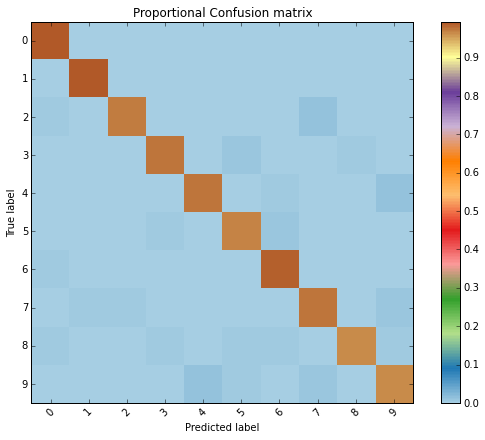

In [33]:
target_names     = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

predicted_values = estimator.predict(testX)
y_true, y_pred   = testY, predicted_values

#print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)  

print(cm)
model_accuracy = sum(cm.diagonal())/len(testY)
model_misclass = 1 - model_accuracy
print("\nModel accuracy: {0}, model misclass rate: {1}".format(model_accuracy, model_misclass))

plot_confusion_matrix(cm, target_names)

##Print a random sample of predictions

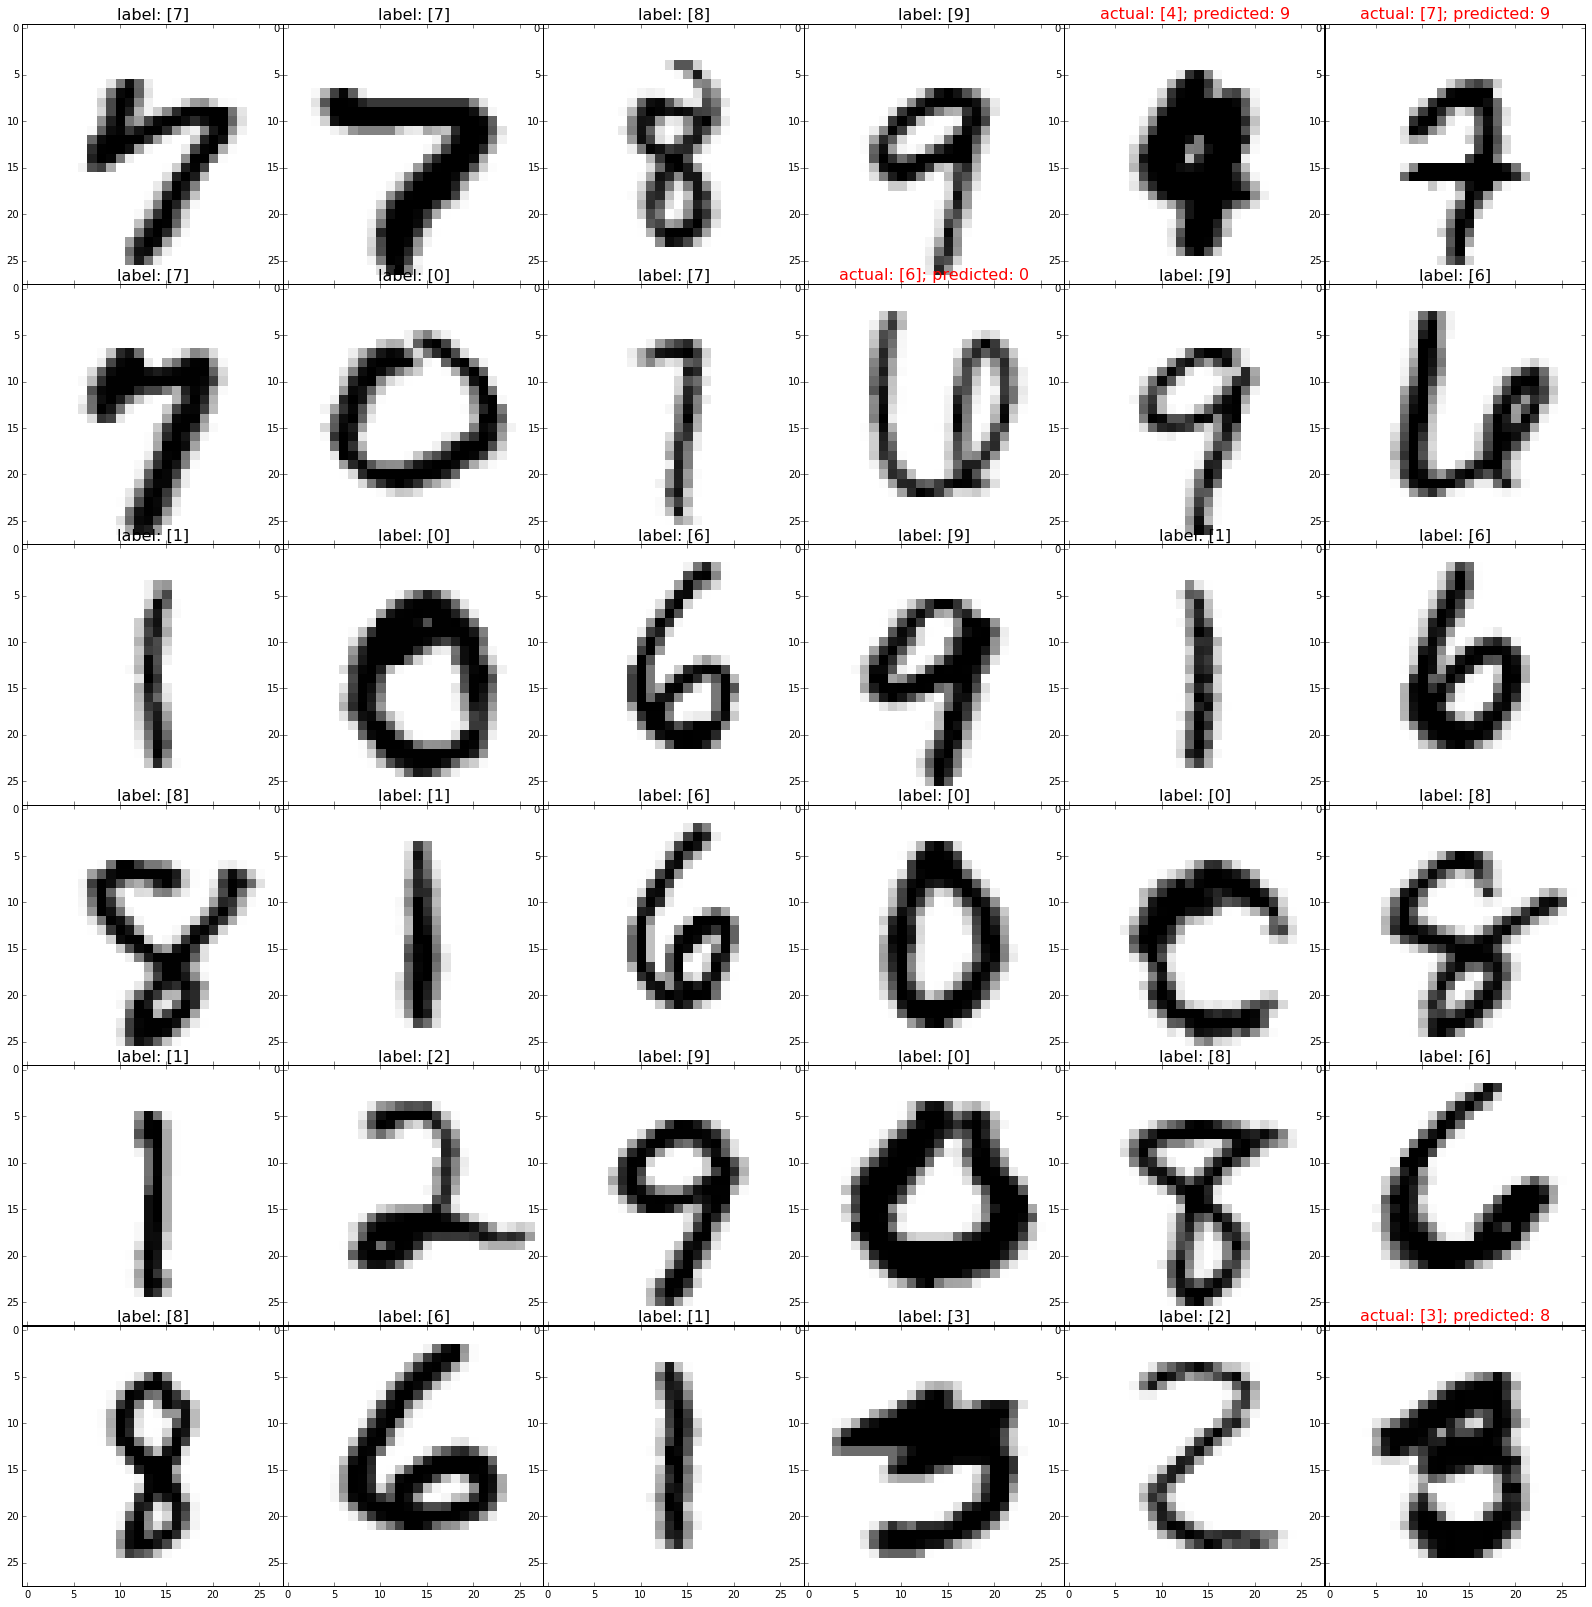

In [ ]:
print_imgs(images           = testX, 
           actual_labels    = y_true, 
           predicted_labels = y_pred,
           starting_index   = np.random.randint(0, high=testY.shape[0]-36, size=1)[0],
           size             = 6)

##Learning Curves   

1. do we predict the training data well? (flat red line hugs the 1.0 line)
2. does the prediction improve with more data? (green line increases from left to right)

In [ ]:
t0 = time.time()

parm_list = ""
for i, param in enumerate(estimator.best_params_):
    if i % 3 == 0: parm_list += "\n"
    param_val = estimator.best_params_[param]
    parm_list += param + "=" + str(param_val) + " "


plot_learning_curve(estimator = estimator.best_estimator_, 
                    title     = "KNN" + parm_list, 
                    X         = trainX, 
                    y         = trainY, 
                    ylim      = (0.85, 1.01), 
                    cv        = ShuffleSplit(n            = trainX.shape[0], 
                                             n_iter       = 5, 
                                             test_size    = 0.2, 
                                             random_state = 0), 
                    n_jobs      = -1)

plt.show()

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))